# Predict basal area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular import *

Run the example workflow for predicting the basal area of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
preprocessor = EnvecoPreprocessor('../../enveco_data/enveco/AV.leaf.on.train.csv', 
                                  '../../enveco_data/enveco/AV.leaf.on.val.csv',
                                  '../../enveco_data/enveco/AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [53]:
trainval_tb

     sampleplotid             x          y  measurementdate         g  \
0          901034  313598.50000  6888193.5             2013  3.433987   
1          901038  314591.78125  6888462.0             2013  2.975530   
2          901044  317890.37500  6888182.5             2013  3.325036   
3          901048  318879.40625  6888447.5             2013  3.563883   
4          901054  322193.40625  6888196.0             2013  2.694627   
..            ...           ...        ...              ...       ...   
220        923107  344428.15625  6983045.0             2013  2.965273   
221        923124  352291.12500  6982801.0             2013  3.292126   
222        923136  357086.46875  6983047.5             2013  1.648659   
223        923138  357588.28125  6983052.0             2013  3.421000   
224        923142  360885.68750  6982306.0             2013  3.206803   

             d          h           v        v_ma        v_ku  ...       d00  \
0    25.900000  23.900000  336.619995   50.

In [5]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='g', path='../../enveco_data/enveco/AV_las/', min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=True)

Adding height based features
Adding point distribution based features
Adding intensity based features
Adding height quantiles
Adding point proportions
Adding canopy densities


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [6]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [7]:
trainval_tb.train.y.describe()

count    1044.000000
mean        2.903793
std         0.473430
min         0.530628
25%         2.653242
50%         2.954910
75%         3.234749
max         4.226834
Name: g, dtype: float64

In [8]:
trainval_tb.valid.y.describe()

count    225.000000
mean       2.900115
std        0.489632
min        0.470004
25%        2.646175
50%        2.960105
75%        3.206803
max        3.903991
Name: g, dtype: float64

In [9]:
test_tb.train.y.describe()

count    225.000000
mean       2.919878
std        0.489392
min        0.875469
25%        2.681021
50%        2.970414
75%        3.238678
max        3.962716
Name: g, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 70 m² as the maximum value for basal area.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [46]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,5), config={'act_cls': Mish()})
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 58'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
Linear               64 x 200             11,600     True      
________________________________________________________________
Mish                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
Mish                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.25118863582611084)

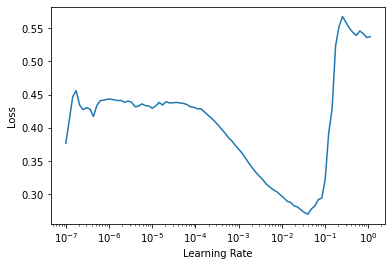

In [47]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.346739,0.236155,0.485958,16.756508,-0.374883,-12.926501,0.418289,0.010554,00:00
1,0.222737,0.063108,0.251214,8.662195,-0.058647,-2.022230,0.189883,0.735588,00:00
2,0.150830,0.050328,0.224339,7.735511,0.011182,0.385563,0.161912,0.789136,00:00
3,0.112357,0.045582,0.213500,7.361762,-0.004187,-0.144367,0.151147,0.809020,00:00
4,0.090735,0.042871,0.207054,7.139509,-0.012681,-0.437258,0.150871,0.820377,00:00
5,0.075986,0.041673,0.204140,7.039048,0.008505,0.293257,0.148579,0.825396,00:00
6,0.065080,0.041161,0.202881,6.995621,-0.015103,-0.520778,0.145086,0.827544,00:00
7,0.056800,0.040634,0.201579,6.950717,0.024737,0.852971,0.140111,0.829751,00:00
8,0.050762,0.038703,0.196731,6.783571,0.014076,0.485346,0.138579,0.837841,00:00
9,0.046172,0.038933,0.197313,6.803638,0.008595,0.296384,0.139321,0.836880,00:00


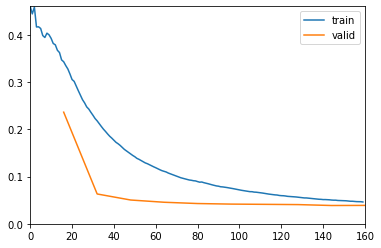

In [48]:
learn.fit_one_cycle(10, max_lr=1e-2, cbs=ShowGraphCallback())

See validation results

In [49]:
learn.validate()

(#7) [0.03893253579735756,0.19731329381465912,6.803638458251953,0.008595479652285576,0.29638418555259705,0.13932137191295624,0.8368798050916748]

`RegressionInterpretation` can be used to plot results.

In [50]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

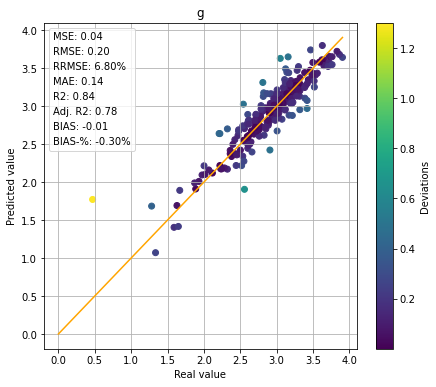

In [51]:
reg_interp.plot_results()
plt.show()

If target variable is log-transformed, specify `log_y = True` to inverse transformations.

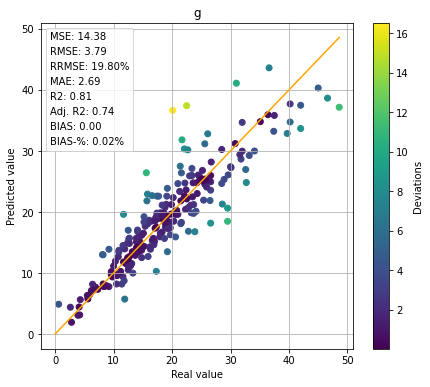

In [52]:
reg_interp.plot_results(log_y=True)
plt.show()

Evaluate test set.

In [21]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [22]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls)

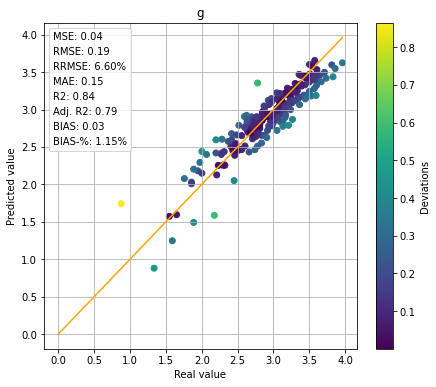

In [23]:
test_interp.plot_results()
plt.show()

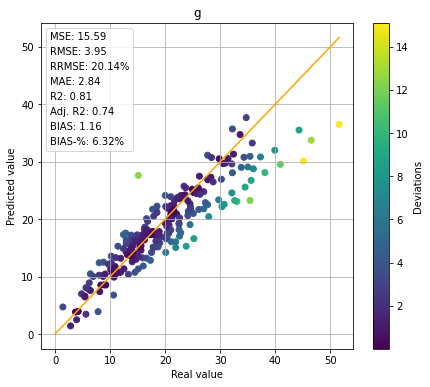

In [24]:
test_interp.plot_results(log_y=True)
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [25]:
ensemble = ANNEnsemble(dls, 
                       y_range=(0,5), 
                       metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], n_models=10,
                      config={'act_cls': Mish()})

In [26]:
ensemble.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.217649,0.125510,0.354274,12.215858,-0.207201,-7.144591,0.288145,0.474136,00:00
1,0.148529,0.060692,0.246358,8.494755,-0.015950,-0.549995,0.181704,0.745711,00:00
2,0.106208,0.048960,0.221269,7.629678,0.007218,0.248889,0.160536,0.794866,00:00
3,0.085543,0.052175,0.228419,7.876197,0.021298,0.734399,0.164532,0.781396,00:00
4,0.072127,0.039976,0.199939,6.894188,-0.013773,-0.474913,0.150554,0.832509,00:00
5,0.063950,0.043286,0.208052,7.173934,-0.004253,-0.146654,0.154309,0.818641,00:00
6,0.055620,0.043579,0.208755,7.198167,0.000742,0.025589,0.153181,0.817413,00:00
7,0.049897,0.039975,0.199937,6.894093,0.004793,0.165259,0.146235,0.832514,00:00
8,0.045788,0.040834,0.202074,6.967783,0.016444,0.567011,0.146757,0.828914,00:00
9,0.043950,0.040257,0.200642,6.918432,0.010895,0.375685,0.147250,0.831329,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.340184,0.209336,0.457533,15.776369,-0.331570,-11.432983,0.387664,0.122920,00:00
1,0.225437,0.086313,0.293791,10.130334,-0.009972,-0.343862,0.219334,0.638363,00:00
2,0.150810,0.057794,0.240403,8.289428,-0.005735,-0.197755,0.179283,0.757856,00:00
3,0.112850,0.046421,0.215455,7.429178,-0.014657,-0.505401,0.157130,0.805506,00:00
4,0.092402,0.048555,0.220352,7.598028,-0.004470,-0.154146,0.163480,0.796564,00:00
5,0.078634,0.045565,0.213459,7.360362,-0.011302,-0.389718,0.152414,0.809092,00:00
6,0.067946,0.046281,0.215130,7.417991,0.029901,1.031038,0.154288,0.806091,00:00
7,0.059512,0.043024,0.207422,7.152217,0.001983,0.068382,0.150227,0.819737,00:00
8,0.053355,0.043111,0.207632,7.159434,-0.003601,-0.124154,0.148932,0.819373,00:00
9,0.048417,0.042985,0.207328,7.148955,0.006241,0.215186,0.148195,0.819901,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.386514,0.277819,0.527085,18.174629,-0.417957,-14.411735,0.460178,-0.164009,00:00
1,0.261445,0.093289,0.305433,10.531761,-0.122476,-4.223140,0.242278,0.609135,00:00
2,0.174224,0.047580,0.218129,7.521400,-0.030440,-1.049624,0.165079,0.800647,00:00
3,0.128217,0.047951,0.218978,7.550677,0.010684,0.368414,0.157179,0.799092,00:00
4,0.101250,0.041963,0.204848,7.063431,0.005192,0.179026,0.152795,0.824185,00:00
5,0.082963,0.043062,0.207514,7.155382,-0.006499,-0.224109,0.154067,0.819577,00:00
6,0.068760,0.042134,0.205265,7.077812,-0.013726,-0.473299,0.152204,0.823468,00:00
7,0.059354,0.041157,0.202872,6.995297,0.009998,0.344743,0.146806,0.827560,00:00
8,0.053001,0.039558,0.198891,6.858052,0.001767,0.060922,0.142090,0.834260,00:00
9,0.048317,0.039669,0.199171,6.867682,0.010887,0.375399,0.140992,0.833794,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.208667,0.143709,0.379089,13.071531,-0.230709,-7.955157,0.312384,0.397887,00:00
1,0.138412,0.072101,0.268516,9.258823,-0.075448,-2.601565,0.204974,0.697910,00:00
2,0.103571,0.042447,0.206027,7.104107,-0.036677,-1.264678,0.157198,0.822154,00:00
3,0.083259,0.044393,0.210695,7.265071,-0.007428,-0.256143,0.162394,0.814003,00:00
4,0.072283,0.047409,0.217736,7.507839,-0.005097,-0.175746,0.162274,0.801365,00:00
5,0.062917,0.042943,0.207227,7.145479,-0.002284,-0.078753,0.154285,0.820077,00:00
6,0.054851,0.036457,0.190938,6.583811,-0.005884,-0.202896,0.142849,0.847250,00:00
7,0.049744,0.036583,0.191266,6.595116,-0.011624,-0.400807,0.144249,0.846725,00:00
8,0.045391,0.036151,0.190135,6.556128,0.006148,0.211989,0.142118,0.848532,00:00
9,0.041587,0.035080,0.187297,6.458264,0.001620,0.055871,0.139633,0.853020,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.387256,0.261870,0.511732,17.645231,-0.389414,-13.427545,0.439184,-0.097185,00:00
1,0.258253,0.098443,0.313756,10.818736,-0.085473,-2.947221,0.238785,0.587543,00:00
2,0.170886,0.052526,0.229185,7.902629,0.002203,0.075970,0.173006,0.779926,00:00
3,0.125877,0.051121,0.226099,7.796224,0.023659,0.815785,0.164107,0.785813,00:00
4,0.098624,0.046351,0.215293,7.423619,-0.031780,-1.095818,0.160910,0.805797,00:00
5,0.079603,0.045898,0.214238,7.387228,0.013632,0.470063,0.158629,0.807696,00:00
6,0.066547,0.042151,0.205308,7.079314,0.007436,0.256388,0.147886,0.823393,00:00
7,0.059169,0.043212,0.207875,7.167809,-0.002411,-0.083134,0.151030,0.818950,00:00
8,0.051789,0.042029,0.205009,7.068986,0.004620,0.159292,0.148226,0.823908,00:00
9,0.046924,0.042005,0.204951,7.066996,0.007280,0.251037,0.147424,0.824007,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.280512,0.197836,0.444788,15.336905,-0.334077,-11.519430,0.379505,0.171103,00:00
1,0.183505,0.052228,0.228534,7.880185,-0.086765,-2.991763,0.181843,0.781174,00:00
2,0.130098,0.038492,0.196195,6.765070,-0.022655,-0.781168,0.143965,0.838724,00:00
3,0.102513,0.038199,0.195447,6.739281,0.003634,0.125298,0.143078,0.839951,00:00
4,0.082471,0.040042,0.200104,6.899877,0.021410,0.738238,0.145096,0.832232,00:00
5,0.069322,0.038800,0.196977,6.792034,0.018332,0.632101,0.140971,0.837436,00:00
6,0.059764,0.037681,0.194116,6.693403,0.000291,0.010034,0.141644,0.842123,00:00
7,0.052640,0.037243,0.192984,6.654342,0.011364,0.391851,0.141648,0.843960,00:00
8,0.047477,0.037592,0.193887,6.685501,0.018456,0.636381,0.141774,0.842495,00:00
9,0.044770,0.037263,0.193036,6.656148,0.018598,0.641274,0.141037,0.843875,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.311911,0.199760,0.446946,15.411311,-0.298909,-10.306784,0.375278,0.163040,00:00
1,0.206084,0.074899,0.273676,9.436749,-0.072369,-2.495384,0.214357,0.686188,00:00
2,0.144537,0.052265,0.228616,7.882991,0.013264,0.457353,0.172918,0.781019,00:00
3,0.109336,0.041432,0.203548,7.018608,-0.027785,-0.958075,0.151950,0.826409,00:00
4,0.087327,0.042611,0.206423,7.117761,0.011748,0.405090,0.150864,0.821470,00:00
5,0.074593,0.047907,0.218877,7.547170,0.036565,1.260814,0.159849,0.799279,00:00
6,0.064448,0.039781,0.199451,6.877347,0.004391,0.151409,0.142439,0.833326,00:00
7,0.056118,0.037828,0.194495,6.706458,0.008856,0.305357,0.140212,0.841506,00:00
8,0.049899,0.036851,0.191967,6.619276,0.006187,0.213343,0.136950,0.845600,00:00
9,0.046438,0.037035,0.192446,6.635805,-0.005431,-0.187266,0.138123,0.844828,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.234110,0.170357,0.412743,14.231959,-0.272745,-9.404635,0.338979,0.286236,00:00
1,0.154316,0.058576,0.242025,8.345351,-0.057553,-1.984500,0.185213,0.754577,00:00
2,0.112911,0.050238,0.224139,7.728627,0.032042,1.104852,0.169217,0.789511,00:00
3,0.086540,0.043882,0.209481,7.223206,-0.016503,-0.569044,0.157479,0.816141,00:00
4,0.072412,0.041355,0.203359,7.012104,-0.017334,-0.597716,0.153657,0.826731,00:00
5,0.062826,0.045300,0.212838,7.338954,0.014684,0.506335,0.152401,0.810201,00:00
6,0.056447,0.041711,0.204234,7.042265,-0.007429,-0.256159,0.153569,0.825237,00:00
7,0.050579,0.041984,0.204900,7.065243,-0.009711,-0.334848,0.151680,0.824094,00:00
8,0.045966,0.041344,0.203333,7.011196,0.013338,0.459903,0.148935,0.826775,00:00
9,0.042895,0.041175,0.202917,6.996873,0.014537,0.501270,0.148575,0.827482,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.215593,0.149617,0.386803,13.337517,-0.239006,-8.241246,0.316671,0.373133,00:00
1,0.147826,0.064705,0.254372,8.771107,-0.012027,-0.414720,0.195404,0.728897,00:00
2,0.107369,0.068367,0.261470,9.015855,-0.002181,-0.075205,0.195557,0.713556,00:00
3,0.088247,0.045480,0.213259,7.353481,0.007763,0.267676,0.157999,0.809449,00:00
4,0.074187,0.040488,0.201217,6.938258,-0.004905,-0.169134,0.147170,0.830361,00:00
5,0.062993,0.041154,0.202863,6.995012,0.017252,0.594877,0.148464,0.827574,00:00
6,0.055872,0.040770,0.201915,6.962302,0.010132,0.349377,0.144895,0.829183,00:00
7,0.050246,0.040886,0.202202,6.972220,-0.003943,-0.135955,0.145743,0.828696,00:00
8,0.046168,0.038597,0.196462,6.774279,0.009833,0.339055,0.142546,0.838285,00:00
9,0.043087,0.038756,0.196866,6.788229,0.016243,0.560077,0.141648,0.837618,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.354287,0.235115,0.484886,16.719559,-0.377271,-13.008818,0.421405,0.014912,00:00
1,0.227035,0.073539,0.271181,9.350688,-0.072661,-2.505455,0.213155,0.691885,00:00
2,0.158600,0.062501,0.250001,8.620391,-0.008176,-0.281903,0.195290,0.738134,00:00
3,0.119643,0.044431,0.210786,7.268209,0.001668,0.057510,0.160229,0.813843,00:00
4,0.096571,0.048968,0.221287,7.630278,0.009932,0.342453,0.164989,0.794834,00:00
5,0.080475,0.041295,0.203212,7.007021,0.015715,0.541867,0.153594,0.826982,00:00
6,0.068444,0.041186,0.202943,6.997751,-0.004095,-0.141205,0.150214,0.827439,00:00
7,0.059416,0.042976,0.207306,7.148189,0.017926,0.618123,0.154968,0.819940,00:00
8,0.052983,0.040954,0.202371,6.978049,0.008465,0.291902,0.150631,0.828409,00:00
9,0.047791,0.040481,0.201199,6.937620,0.008117,0.279897,0.149456,0.830392,00:00


In [27]:
res = ensemble.validate()

See ensemble validation results.

In [28]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,0.191600,6.606653,0.008899,0.306843,0.138741,0.846189
1,0,0.200642,6.918432,0.010895,0.375685,0.147250,0.831329
2,1,0.207328,7.148955,0.006241,0.215186,0.148195,0.819901
3,2,0.199171,6.867682,0.010887,0.375399,0.140992,0.833794
4,3,0.187297,6.458264,0.001620,0.055871,0.139633,0.853020
5,4,0.204951,7.066996,0.007280,0.251037,0.147424,0.824007
6,5,0.193036,6.656148,0.018598,0.641274,0.141037,0.843875
7,6,0.192446,6.635805,-0.005431,-0.187266,0.138123,0.844828
8,7,0.202917,6.996873,0.014537,0.501270,0.148575,0.827482
9,8,0.196866,6.788229,0.016243,0.560077,0.141648,0.837618


In [29]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

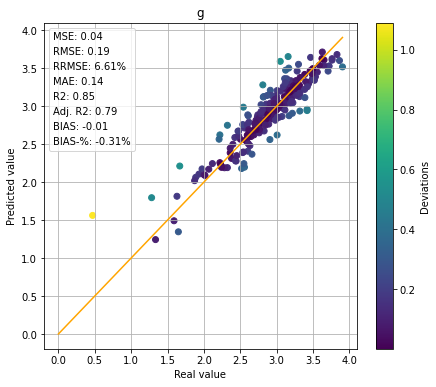

In [30]:
ens_int.plot_results()
plt.show()

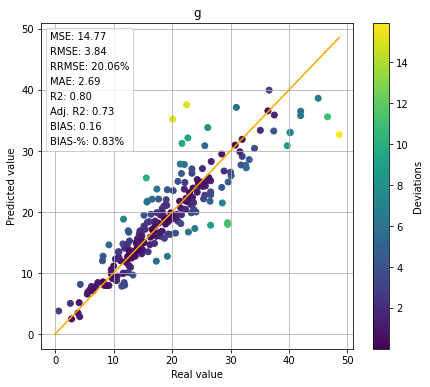

In [31]:
ens_int.plot_results(log_y=True)
plt.show()

Run test set predictions.

In [32]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,0.182127,6.237490,-0.021579,-0.739051,0.139452,0.860886
1,0,0.193803,6.637362,-0.021762,-0.745296,0.150727,0.842478
2,1,0.194946,6.676503,-0.029822,-1.021354,0.150414,0.840615
3,2,0.191556,6.560397,-0.014363,-0.491915,0.144587,0.846110
4,3,0.189824,6.501078,-0.029527,-1.011243,0.143549,0.848880
5,4,0.197444,6.762056,-0.023251,-0.796307,0.154196,0.836504
6,5,0.185309,6.346448,-0.013260,-0.454125,0.143697,0.855984
7,6,0.195114,6.682282,-0.033317,-1.141033,0.147827,0.840339
8,7,0.186740,6.395455,-0.021684,-0.742641,0.143545,0.853751
9,8,0.185353,6.347969,-0.015094,-0.516938,0.143352,0.855915


In [33]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

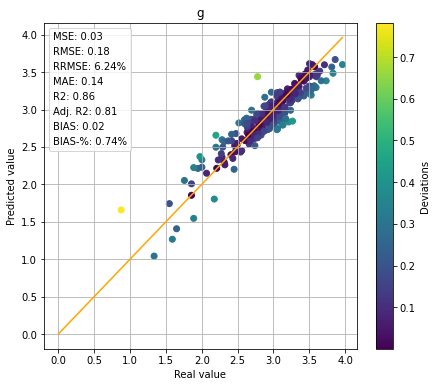

In [34]:
test_ens_interp.plot_results()
plt.show()

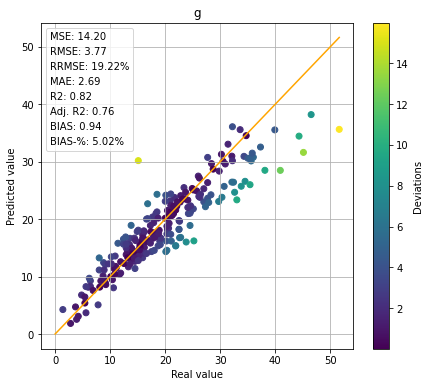

In [35]:
test_ens_interp.plot_results(log_y=True)
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [36]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [37]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [38]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [39]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

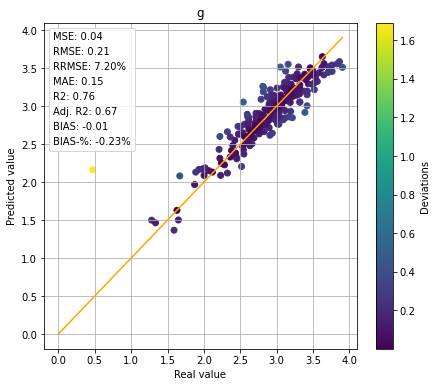

In [40]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

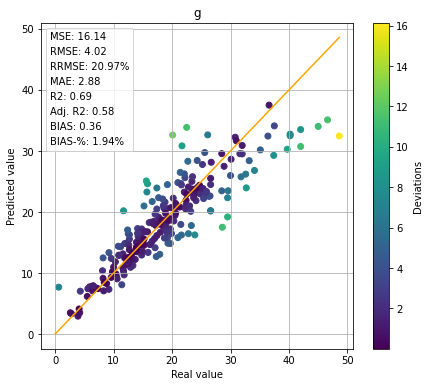

In [41]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=True)
plt.show()

Test results

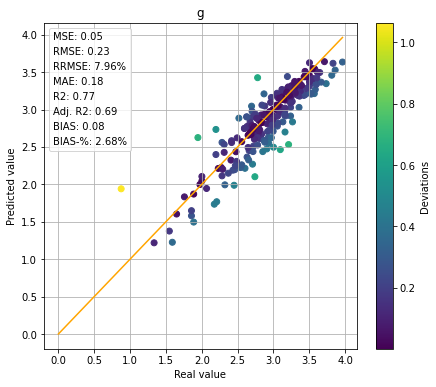

In [42]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

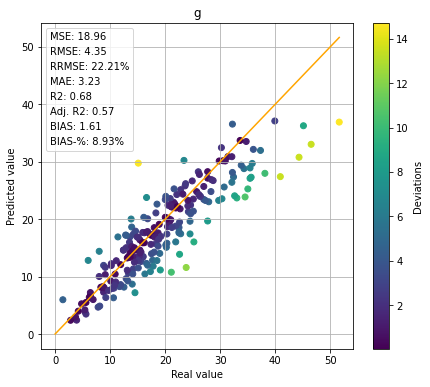

In [43]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys, log_y=True)
plt.show()